In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import joblib


df = pd.read_csv('house_system.csv')
print("Initial Data Shape:", df.shape)
print("\nData Preview:")
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum())



df.dropna(axis=1, how='all', inplace=True)
df.dropna(inplace=True)
print("\nData Shape After Dropping Missing Values:", df.shape)
df.drop_duplicates(inplace=True)


Initial Data Shape: (545, 18)

Data Preview:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  \
0              no             yes        2      yes        furnished   
1              no             yes        3       no        furnished   
2              no              no        2      yes   semi-furnished   
3              no             yes        3      yes        furnished   
4              no             yes        2       no        furnished   

   Unnamed: 13  year_built  year_renovated     

In [2]:

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

num_cols = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
for col in num_cols:
    df = remove_outliers(df, col)




In [3]:

cat_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
            'airconditioning', 'prefarea', 'furnishingstatus', 'city']


encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

In [4]:

df['age'] = 2025 - df['year_built']
df['renovated'] = np.where(df['year_renovated'] > 0, 1, 0)
df.drop(['year_built', 'year_renovated', 'country'], axis=1, inplace=True)



In [11]:

X = df.drop(['price', 'prefarea'], axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [12]:

models = {
    "XGBoost": XGBRegressor(random_state=42, n_estimators=100),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results[name] = {
        'model': model,
        'r2': r2,
        'rmse': rmse
    }
    print(f"{name} - R²: {r2:.4f}, RMSE: {rmse:,.2f}")


XGBoost - R²: 0.4002, RMSE: 1,131,250.53
Random Forest - R²: 0.4493, RMSE: 1,083,990.78


In [13]:

best_model_name = max(results, key=lambda x: results[x]['r2'])
best_model = results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")


Best Model: Random Forest


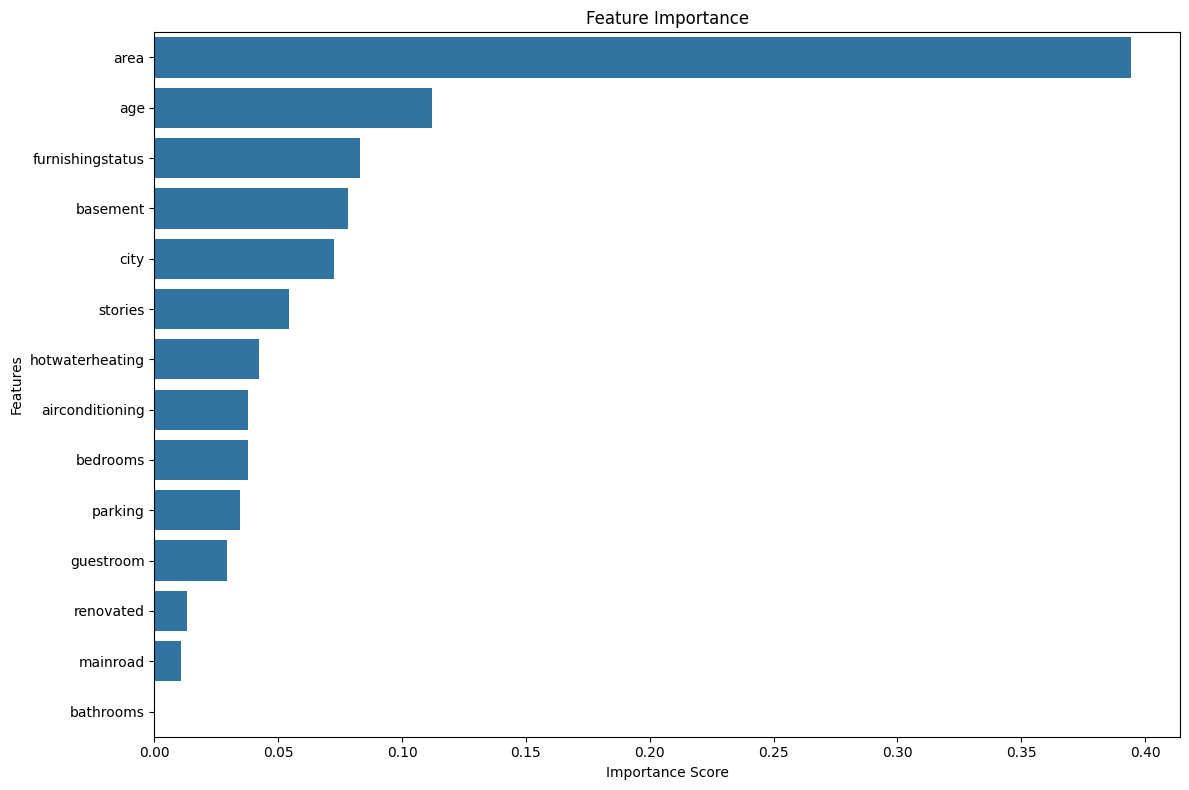

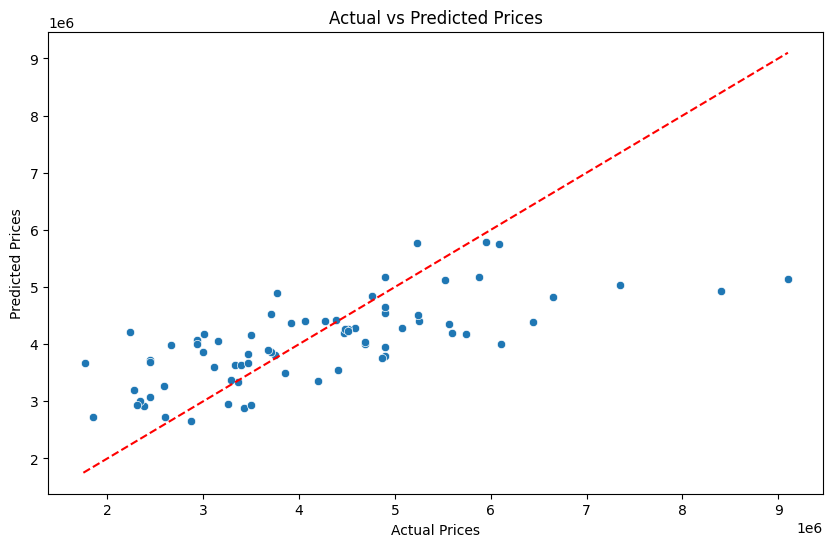

In [14]:

feature_importance = pd.Series(
    best_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.savefig('actual_vs_predicted.png')
plt.show()


In [15]:

joblib.dump(best_model, 'best_house_price_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(encoders, 'label_encoders.joblib')
df.to_csv('preprocessed_house_data.csv', index=False)

print("\nPreprocessed data saved to 'preprocessed_house_data.csv'")
print("Best model saved to 'best_house_price_model.joblib'")
print("Scaler saved to 'scaler.joblib'")
print("Label encoders saved to 'label_encoders.joblib'")


Preprocessed data saved to 'preprocessed_house_data.csv'
Best model saved to 'best_house_price_model.joblib'
Scaler saved to 'scaler.joblib'
Label encoders saved to 'label_encoders.joblib'


In [17]:
import pandas as pd
import joblib


model = joblib.load('best_house_price_model.joblib')
scaler = joblib.load('scaler.joblib')
encoders = joblib.load('label_encoders.joblib')


new_data = pd.DataFrame({
    'area': [7420],
    'bedrooms': [4],
    'bathrooms': [2],
    'stories': [3],
    'mainroad': ['yes'],
    'guestroom': ['no'],
    'basement': ['no'],
    'hotwaterheating': ['no'],
    'airconditioning': ['yes'],
    'parking': [2],
    'furnishingstatus': ['furnished'],
    'city': ['Seattle'],
    'year_built': [2014]
})


new_data['age'] = 2025 - new_data['year_built']
new_data['renovated'] = 0

cat_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
            'airconditioning',  'furnishingstatus', 'city']

for col in cat_cols:

    try:
        new_data[col] = encoders[col].transform(new_data[col])
    except ValueError:

        new_data[col] = encoders[col].transform([encoders[col].classes_[0]])[0]

new_data.drop('year_built', axis=1, inplace=True)


scaled_data = scaler.transform(new_data)
prediction = model.predict(scaled_data)
print(f"Predicted Price: RS{prediction[0]:,.2f}")

Predicted Price: ₹5,046,790.00
